In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target

<Axes: >

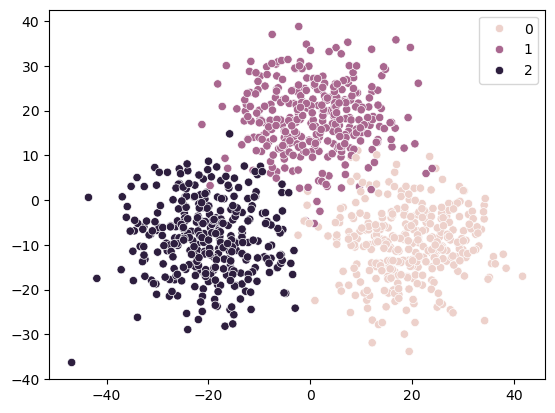

In [2]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [3]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,-6.009666,-2.206114,-13.780420,-21.306485,11.310120,0.782860,-1.417216,-7.132923,4.035716,-9.151141,...,8.056352,0.571816,-12.896272,-14.226178,-6.689985,12.024199,-0.868541,-10.816002,-19.367540,1.0
1,-12.627036,4.174617,-10.076433,-5.044769,-14.043358,0.323991,4.046087,-1.038308,4.320892,1.198225,...,7.384793,-1.266326,9.103606,-0.447654,-6.388030,-4.372140,9.310592,-15.280379,-5.870141,1.0
2,0.050001,-11.648239,-7.450600,13.377213,0.658540,0.358796,7.195505,-13.809483,-7.421310,-4.862660,...,-1.872640,-0.886235,-9.960326,-1.918039,-17.788577,4.204549,-1.283589,-15.967288,-5.009686,2.0
3,5.969750,-8.190476,1.245406,-3.652785,11.866776,-4.876837,11.597389,-19.595903,-6.570676,0.846062,...,-16.098316,-6.953340,-5.883746,3.629998,-2.072178,-10.902164,-8.747176,-16.130198,9.850313,2.0
4,3.910935,3.025328,3.967197,-26.513024,-2.054760,20.113429,0.809374,9.339223,-0.818713,-1.613616,...,-5.931717,5.726328,-8.729363,-13.168305,-15.959724,6.830038,22.986628,-6.985210,4.925417,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-16.058190,-13.067932,-2.836506,-6.595165,3.173786,3.627535,-8.522253,-7.600203,0.170785,-12.011941,...,2.787039,13.639717,9.285745,-7.091496,-5.731880,-4.108219,15.454568,-10.449379,-4.433086,1.0
996,12.760758,-8.912694,-11.031455,12.223111,-7.798058,-6.802161,1.727742,-6.484462,-21.704184,9.338369,...,-7.163893,1.927543,-6.432276,-0.831562,-7.411691,-7.858541,-5.125561,-9.142815,-0.220543,2.0
997,12.707546,6.348988,11.635191,-1.296260,-0.727993,14.533143,-4.251601,-7.453112,-19.904960,13.376828,...,-7.055074,12.351402,-5.138332,-6.394794,-8.215113,9.043282,11.966833,-3.952639,7.368497,0.0
998,8.378194,-2.494219,-9.172657,-10.437750,-14.649131,-15.693282,-13.050502,-13.783132,-0.798388,9.874597,...,0.660304,11.515022,-9.081295,-8.110466,4.271122,-29.061968,-8.120754,-6.981703,7.769794,2.0


<Axes: >

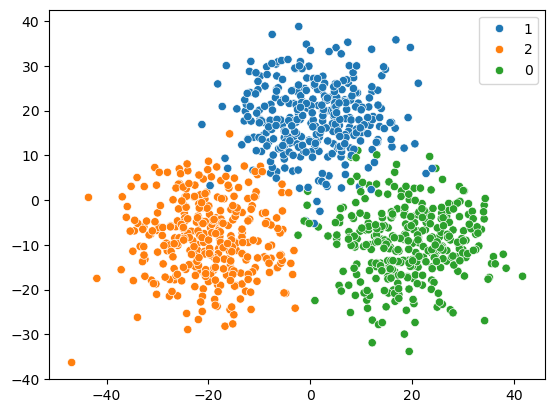

In [4]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [5]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]
    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))
    counterfactuals, ranker = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction #, data_analyzer, ranker, model


In [6]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
t = Target(target_type="classification", target_feature="label", target_value=0)

cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)

Point prediction:  1 <class 'int'>
--- Executing... Initial Instance: 0 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (671) CFs (0)
Re-training surrogate model with data size: 671
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (5) Unique overall (5)
Generated random instances: (3217)
Predicted top: 20 Counterfactuals: 1
Found new best [ -9.37817265  -2.20611361  10.72995378 -21.3064851   -0.
   0.78285955   2.15259505  -7.13292344   4.03571607  12.32673904
  10.86002378   8.05635151   5.41164314 -17.2570137  -14.22617799
  -6.6899847   12.02419881  -0.86854116 -10.81600238 -19.36753979], with fitness score 0.5135 (X 0.85582 Y 1.0 F 0.6), oversampling
Known alternatives: 691
Best instance score 0.5135 (X 0.85582 Y 1.0 F 0.6), found on epoch: 1
Re-training surrogate model with data size: 701
--- epoch 2 ----
Generating neighbo

<Axes: >

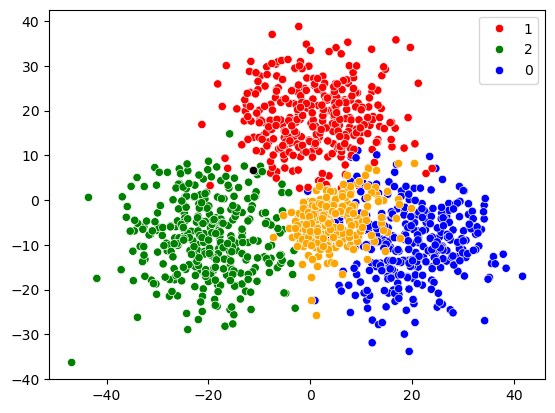

In [7]:
embed_cf = pca.transform(cf)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')